In [1]:
import pandas as pd
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df=df.sort_values(by="QED")
df

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


,Standardized_SMILES,pchembl_value,MolWt,LogP,QED
734,Cc1ccc2c(-c3nnc(SCCCN4CCc5ccc6oc(C(F)(F)C(F)(F...,6.60,602.633,6.71702,0.116412
717,Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6nc(C(F)(F)C(F)(F)...,7.00,602.633,6.71702,0.116412
694,Cc1ccc2c(-c3nnc(SCCCCN4CCc5cc6nc(C(F)(F)F)oc6c...,6.60,645.549,7.23432,0.136623
217,CCc1nc2cc3c(c(Br)c2o1)CCN(CCCCSc1nnc(-c2cccc4n...,5.80,605.606,6.77792,0.142700
712,Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6nc(C(C)(C)C)oc6c(...,6.40,619.633,7.12292,0.148044
...,...,...,...,...,...
618,COc1ccccc1CC(c1ccccc1)N1CCNCC1,4.41,296.414,2.88420,0.917990
1044,NC(=O)c1cccc(OC2CC3CCC(C2)N3C2CCCCC2)c1,7.82,328.456,3.49240,0.920243
60,CC(C)CN(C(=O)c1cccc(Cl)c1Cl)C1CCNC1,4.70,315.244,3.45350,0.922780
1248,Oc1cccc(OC2CC3CCC(C2)N3Cc2ccccc2)c1,5.80,309.409,3.96660,0.927450


In [2]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=20488):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [3]:
smiles = df['Standardized_SMILES'].values

In [4]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    rmse=list()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        model = nn.MLPRegressor(hidden_layer_sizes=(min(25,round(np.sqrt(X_train.shape[0])),)), random_state=42)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("qed_sorted_fcv_results_MLP_training batches.csv", index=False)
    test_df.to_csv("qed_sorted_fcv_results_MLP_testing batches.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
    })


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=-0.1936134400351007, pvalue=0.029837263654370925)
PearsonRResult(statistic=0.4329418342967448, pvalue=4.1224616601541353e-07)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.2725129462022634, pvalue=0.002021118081661215)
PearsonRResult(statistic=0.6815752137010196, pvalue=1.5768433402085903e-18)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.7557132152678789, pvalue=1.511350157156601e-24)
PearsonRResult(statistic=-0.12028999746922499, pvalue=0.17970230316101127)
PearsonRResult(statistic=0.6660764241894475, pvalue=1.7290687359763737e-17)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.4878672447658971, pvalue=6.860115075721037e-09)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.8161705552332272, pvalue=8.364599667474472e-32)


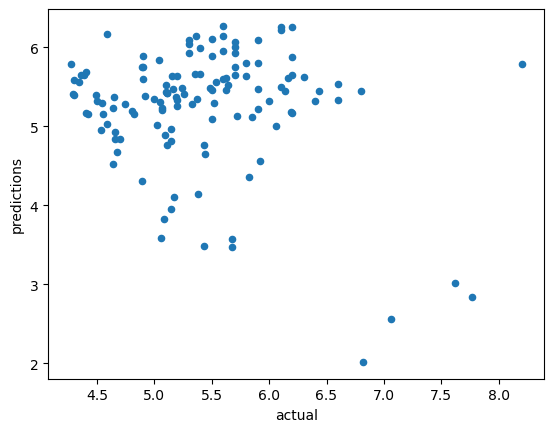

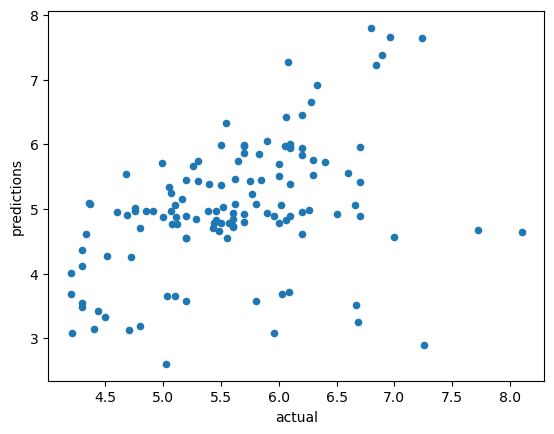

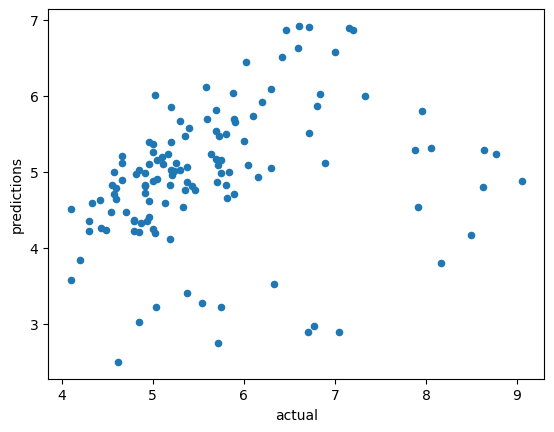

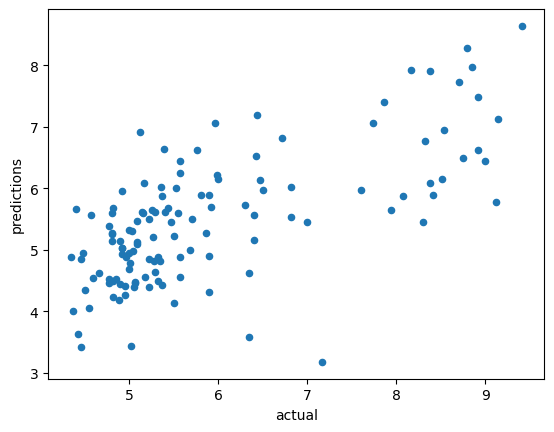

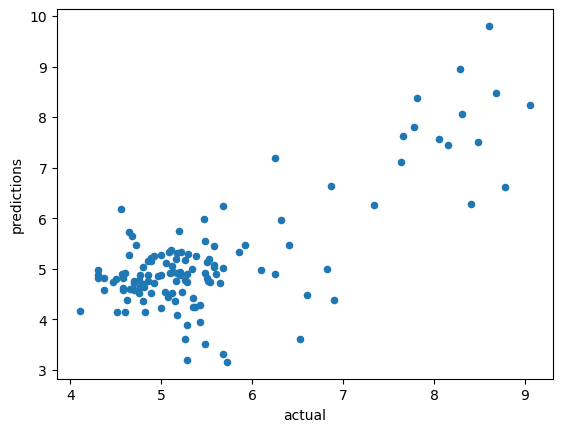

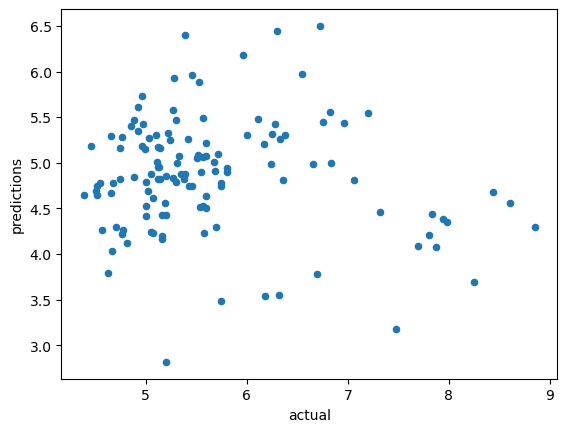

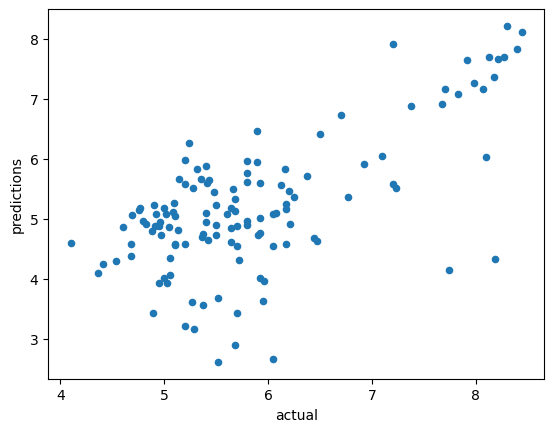

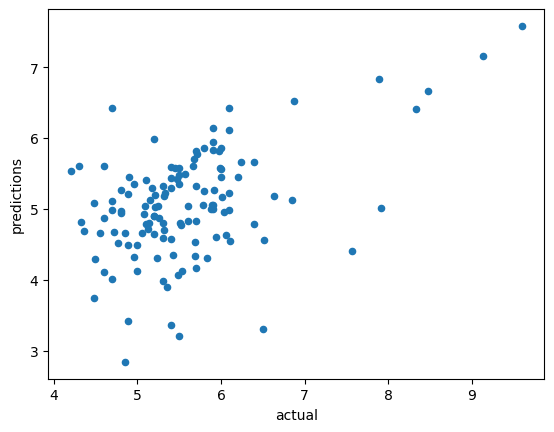

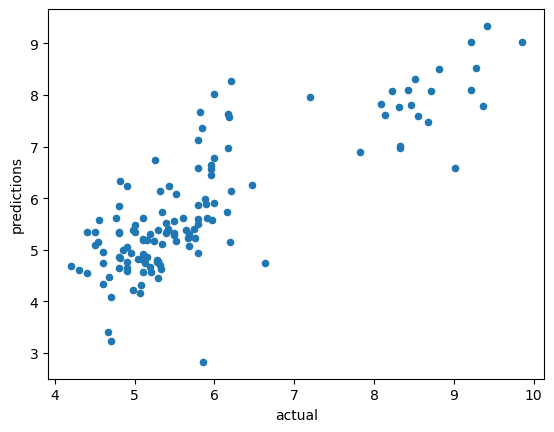

In [6]:
# Example Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [7]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(21, 3)
(34, 3)
(46, 3)
(36, 3)
(50, 3)
(39, 3)
(32, 3)
(29, 3)
(33, 3)


In [8]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(18, 3)
(41, 3)
(36, 3)
(18, 3)
(36, 3)
(48, 3)
(41, 3)
(44, 3)
(14, 3)


In [9]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(33, 3)
(4, 3)
(6, 3)
(15, 3)
(12, 3)
(10, 3)
(3, 3)
(10, 3)
(15, 3)


In [10]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(51, 3)
(42, 3)
(35, 3)
(57, 3)
(28, 3)
(26, 3)
(46, 3)
(39, 3)
(65, 3)


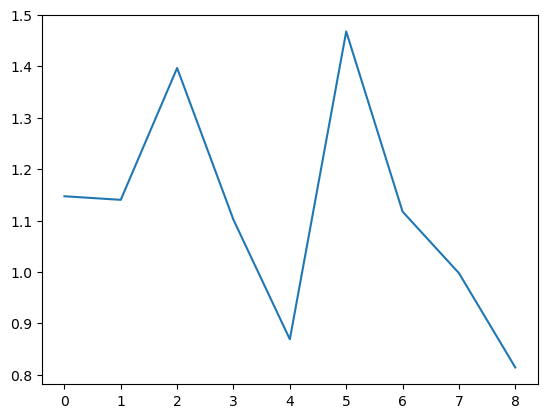

[1.1473262082633755, 1.1404025197413539, 1.3967753961292508, 1.1015403076430743, 0.8691067459222744, 1.4678455118575136, 1.117501085305854, 0.9978017224219004, 0.8143118566940561]


In [11]:
plt.plot(rmse)
plt.show()
print(rmse)

In [12]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

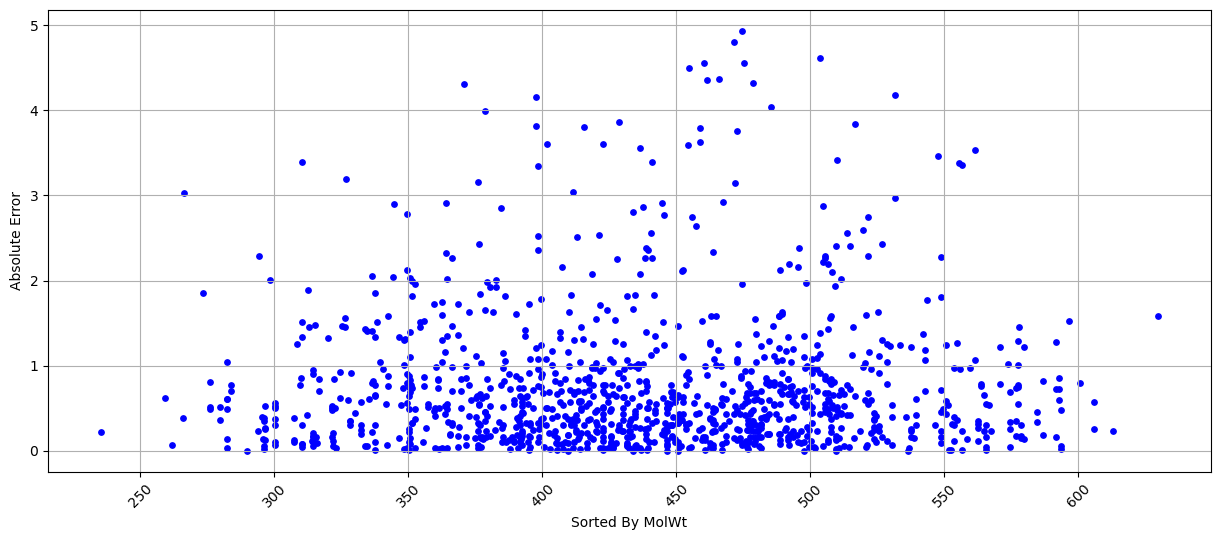

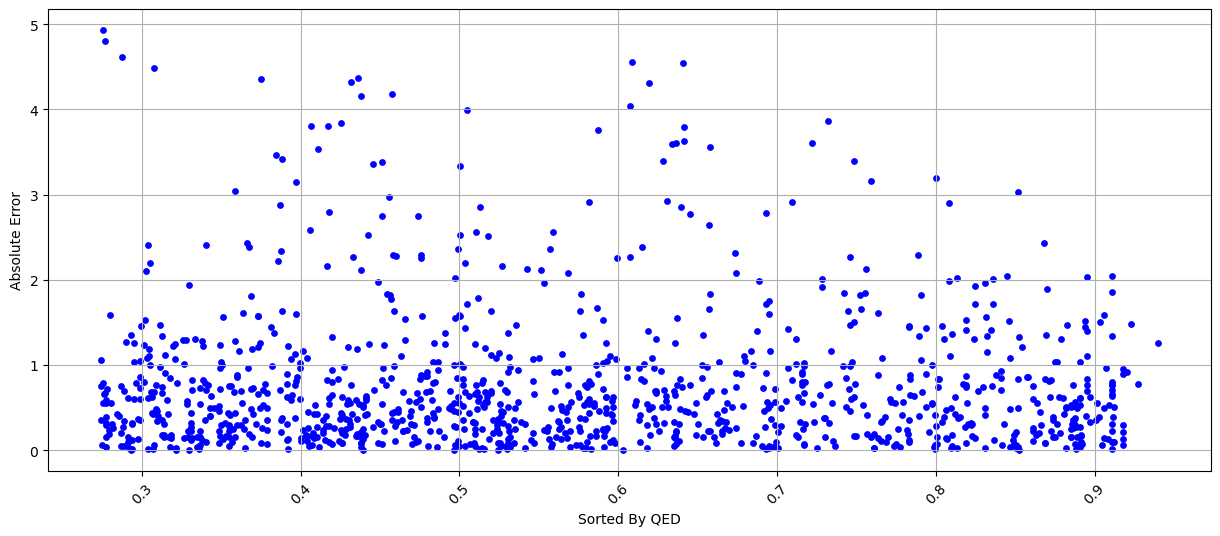

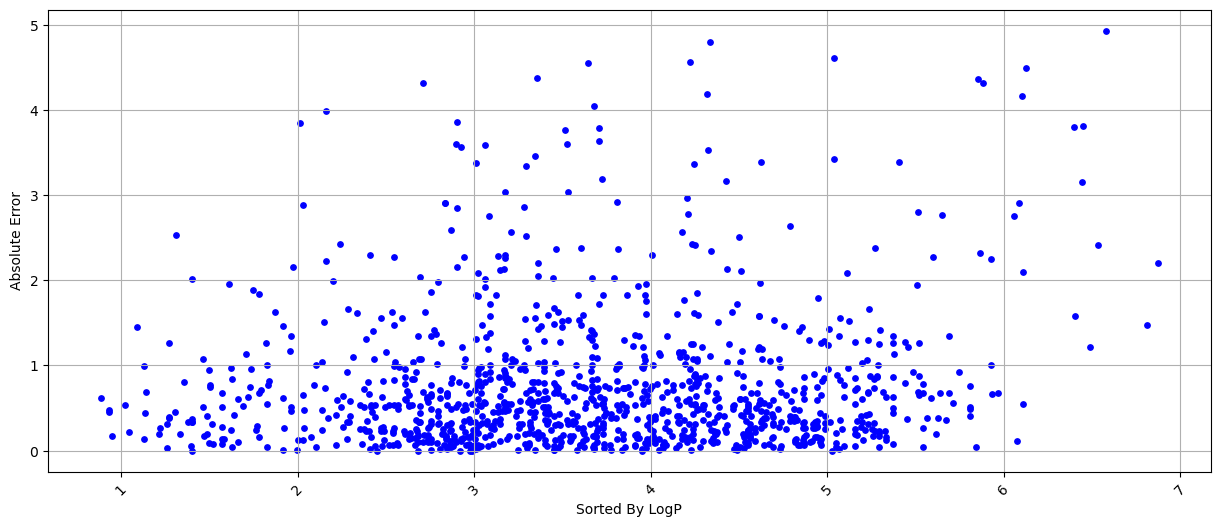

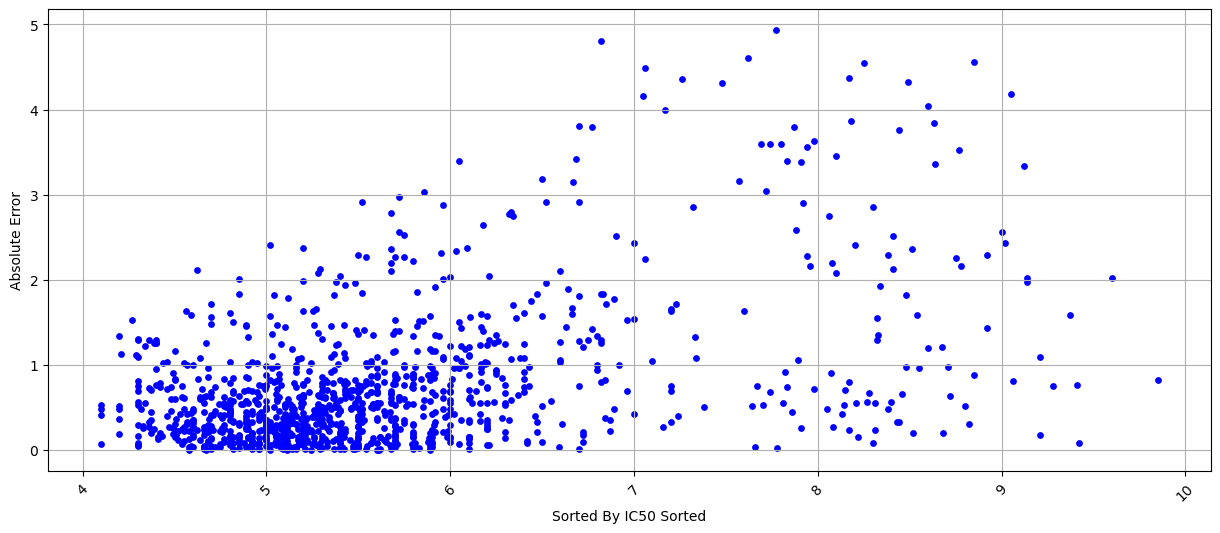

In [13]:
plot_graphs(df, results_df)

In [14]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
734,Cc1ccc2c(-c3nnc(SCCCN4CCc5ccc6oc(C(F)(F)C(F)(F...,6.60,602.633,6.71702,0.116412,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
717,Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6nc(C(F)(F)C(F)(F)...,7.00,602.633,6.71702,0.116412,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
694,Cc1ccc2c(-c3nnc(SCCCCN4CCc5cc6nc(C(F)(F)F)oc6c...,6.60,645.549,7.23432,0.136623,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
217,CCc1nc2cc3c(c(Br)c2o1)CCN(CCCCSc1nnc(-c2cccc4n...,5.80,605.606,6.77792,0.142700,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
712,Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6nc(C(C)(C)C)oc6c(...,6.40,619.633,7.12292,0.148044,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
618,COc1ccccc1CC(c1ccccc1)N1CCNCC1,4.41,296.414,2.88420,0.917990,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1044,NC(=O)c1cccc(OC2CC3CCC(C2)N3C2CCCCC2)c1,7.82,328.456,3.49240,0.920243,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
60,CC(C)CN(C(=O)c1cccc(Cl)c1Cl)C1CCNC1,4.70,315.244,3.45350,0.922780,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1248,Oc1cccc(OC2CC3CCC(C2)N3Cc2ccccc2)c1,5.80,309.409,3.96660,0.927450,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        
        X_test = X[(len(X)-fold_size):(len(X))]
        y_test = y[(len(X)-fold_size):(len(X))]
        smiles_test = smiles[(len(X)-fold_size):(len(X))] 
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = nn.MLPRegressor(hidden_layer_sizes=(min(25,round(np.sqrt(X_train.shape[0])),)), random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("qed_sorted_fcv_results_MLP_training batches_druglike.csv", index=False)
    test_df.to_csv("qed_sorted_fcv_results_MLP_testing batches_druglike.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,

    })


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=0.3552070431688221, pvalue=4.477156857909241e-05)
PearsonRResult(statistic=0.5632629174675852, pvalue=6.609112059189395e-12)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.5549722369178622, pvalue=1.5468752168276893e-11)
PearsonRResult(statistic=0.49052138368037984, pvalue=5.5232652357442265e-09)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.24832553798899587, pvalue=0.00505161473776557)
PearsonRResult(statistic=0.1458465499923377, pvalue=0.10320018637599394)
PearsonRResult(statistic=0.09618427801637297, pvalue=0.2839932276241542)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.7103383593336103, pvalue=1.2243172301506444e-20)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.8161317410599895, pvalue=2.5552705063519366e-31)


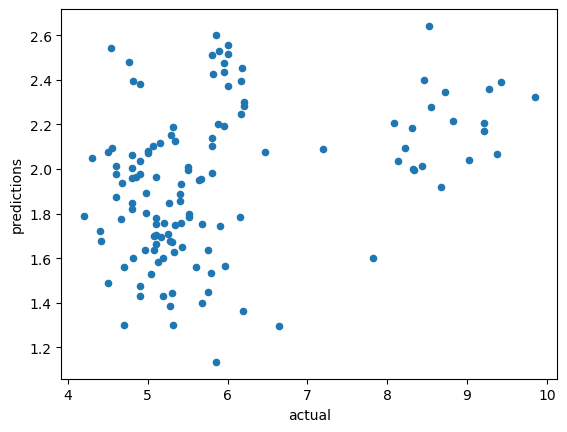

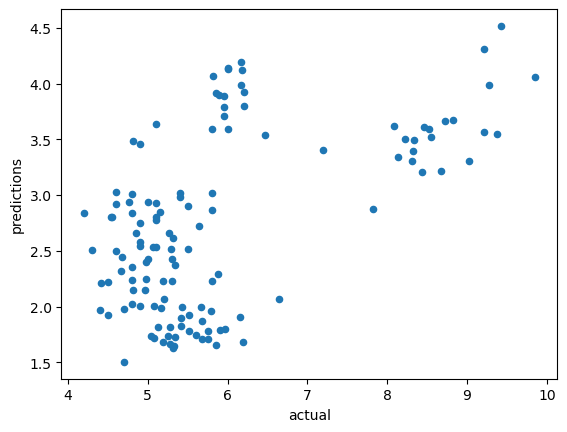

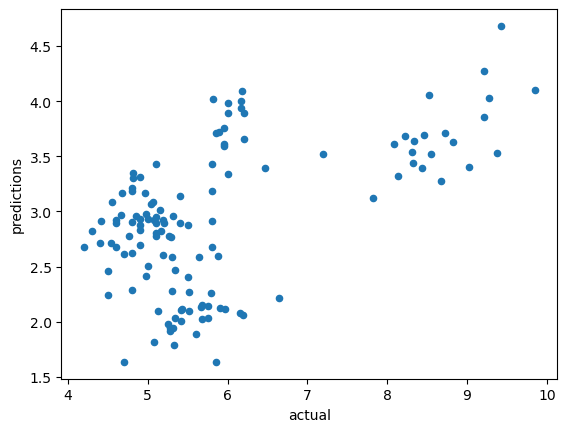

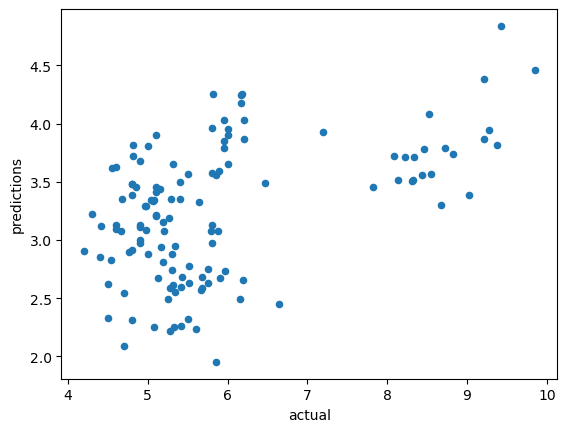

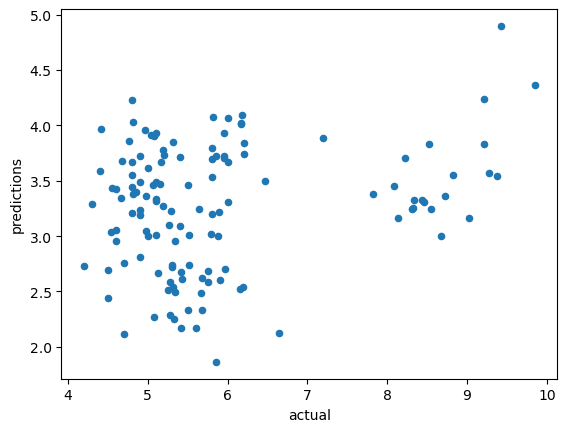

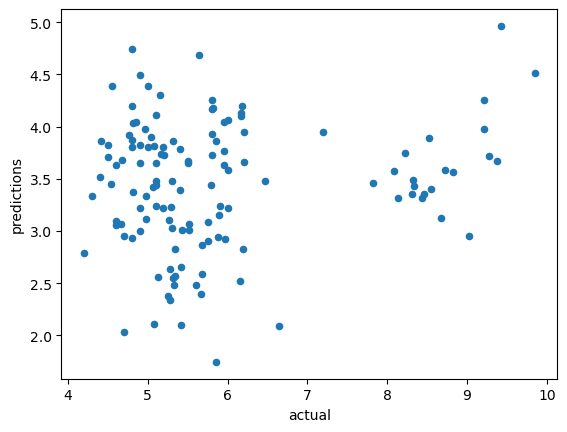

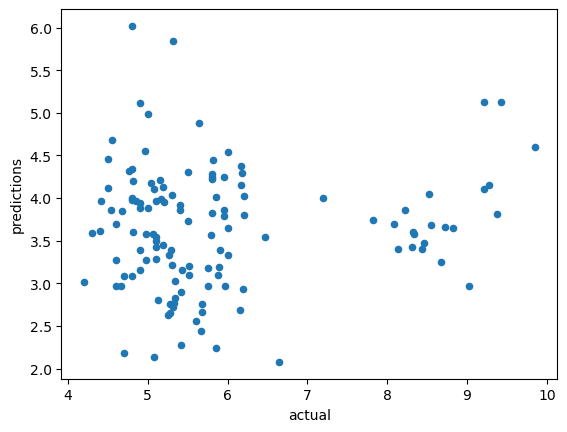

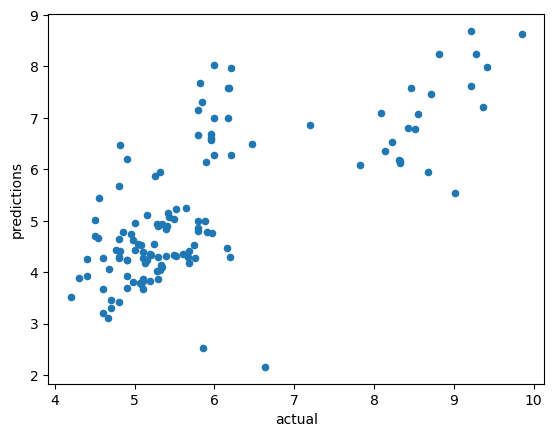

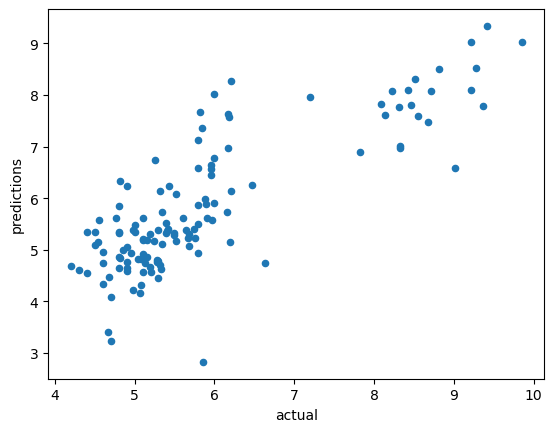

In [16]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [17]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(48, 3)
(48, 3)
(48, 3)
(48, 3)
(48, 3)
(48, 3)
(47, 3)
(44, 3)
(33, 3)


In [18]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(77, 3)
(77, 3)
(77, 3)
(77, 3)
(77, 3)
(77, 3)
(76, 3)
(34, 3)
(14, 3)


In [19]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(1, 3)
(43, 3)
(63, 3)


In [20]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(1, 3)
(4, 3)
(15, 3)


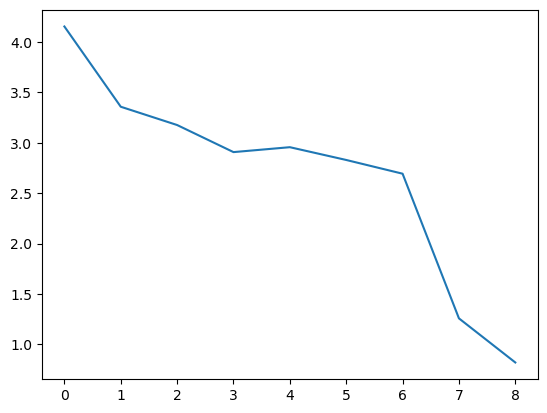

[4.154486824422829, 3.3581429018425424, 3.1766542342376, 2.9079417607865032, 2.9566912581536795, 2.8298980560786187, 2.6936443030197044, 1.2582218827798568, 0.8205239733805111]


In [21]:
plt.plot(rmse)
plt.show()
print(rmse)